# Importing Packages & Set Up Data Layout

## Preprocessing Information for the Given Data.

A high-pass filter with a 30 Hz cut-off frequency and a power line notch filter (50 Hz) were used. All recordings are artifact-free EEG segments of 60 seconds duration. At the stage of data preprocessing, the Independent Component Analysis (ICA) was used to eliminate the artifacts (eyes, muscle, and cardiac overlapping of the cardiac pulsation). The arithmetic task was the serial subtraction of two numbers. Each trial started with the communication orally 4-digit (minuend) and 2-digit (subtrahend) numbers (e.g. 3141 and 42).

In [7]:
# Let's load some packages we need (pip install mne)
import mne
import mne.viz
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.channels import make_standard_montage
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
# ! pip install mne

# Read raw data files where each file contains a run
files = ['../../datasets/HW2Datasets/Subject06_1.edf', '../../datasets/HW2Datasets/Subject06_2.edf', '../../datasets/HW2Datasets/Subject07_1.edf', '../../datasets/HW2Datasets/Subject07_2.edf']

# Read the raw EDF files into an array
raws = [read_raw_edf(f, preload=True) for f in files]

# Loop through the array and make the following changes to the raw files
for raw in raws:

    # Rename the raw channels
    raw.rename_channels({'EEG F3':'F3', 'EEG F4':'F4',
                            'EEG Fp1':'Fp1', 'EEG Fp2':'Fp2', 'EEG F7':'F7', 'EEG F8':'F8',
                            'EEG T3':'T3', 'EEG T4':'T4', 'EEG C3':'C3', 'EEG C4':'C4',
                            'EEG T5':'T5', 'EEG T6':'T6', 'EEG P3':'P3', 'EEG P4':'P4',
                            'EEG O1':'O1', 'EEG O2':'O2', 'EEG Fz':'Fz', 'EEG Cz':'Cz',
                            'EEG Pz':'Pz', 'EEG A2-A1':'A2', 'ECG ECG':'ECG'})


    # Set channel types
    raw.set_channel_types({'ECG':'ecg'})

    # Define the channel locations
    raw.set_montage(mne.channels.make_standard_montage('standard_1020'))

    # Print Raw Channel Names for double checking
    print(raw.ch_names)

# Rename the raws with more insightfull names
subject6_background = raws[0] # Subject 6 background raw
subject6_task = raws[1] # Subject 6 task raw
subject7_background = raws[2] # Subject 7 background raw
subject7_task = raws[3] # Subject 7 task raw

# Function to segment data into non-overlapping windows of length 300 samples
def segment_data(raw, window_size=300):
    data = raw.get_data()  # Get the raw data
    n_channels, n_samples = data.shape
    print("Data Shape Before:", n_channels, n_samples)
    n_windows = n_samples // window_size  # Number of windows

    # Reshape data into (n_channels, n_windows, window_size)
    segmented_data = data[:, :n_windows * window_size].reshape(n_channels, n_windows, window_size)
    print("Data Shape After:", n_channels, n_windows, window_size)


    return segmented_data


# Segment each raw file into windows
subject6_background_segments = segment_data(subject6_background)
subject6_task_segments = segment_data(subject6_task)
subject7_background_segments = segment_data(subject7_background)
subject7_task_segments = segment_data(subject7_task)

# Create labels: 0 for background, 1 for task
subject6_background_labels = np.zeros(subject6_background_segments.shape[1])
subject6_task_labels = np.ones(subject6_task_segments.shape[1])
subject7_background_labels = np.zeros(subject7_background_segments.shape[1])
subject7_task_labels = np.ones(subject7_task_segments.shape[1])

# Concatenate data and labels for both subjects
X = np.concatenate([subject6_background_segments, subject6_task_segments, 
                    subject7_background_segments, subject7_task_segments], axis=1)

y = np.concatenate([subject6_background_labels, subject6_task_labels,
                    subject7_background_labels, subject7_task_labels])

# Reshape the data for model training (n_samples, n_features)
X = X.reshape(X.shape[1], -1)  # (n_windows, n_channels * window_size)

# X shape will be (n_channels, total_windows * window_size), and y will be the labels for each window
print("Shape of segmented data:", X.shape)
print("Shape of labels:", y.shape)

Extracting EDF parameters from /home/joshua/Desktop/MainFolder/OuClasses/2024 Fall/Neural-Data-Science/datasets/HW2Datasets/Subject06_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /home/joshua/Desktop/MainFolder/OuClasses/2024 Fall/Neural-Data-Science/datasets/HW2Datasets/Subject06_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Extracting EDF parameters from /home/joshua/Desktop/MainFolder/OuClasses/2024 Fall/Neural-Data-Science/datasets/HW2Datasets/Subject07_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /home/joshua/Desktop/MainFolder/OuClasses/2024 Fall/Neural-Data-Science/datasets/HW2Datasets/Subject07_2.edf...
EDF file de

# Q1) 
## Split your datasets into 50/50 training and test set. Then, fit a simple logistic regression model to predict the class labels (0 or 1) using the raw data (no feature extraction). Evaluate your model using accuracy, balanced accuracy, and F1 score. Explain what each metric represents and how well your model did using the raw datasets.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score


# Split the dataset into 50% train and 50% test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
print("Total Number of Train Values", len(y_train))
print("Total Number of y=1 Train Values", sum(y_train))

# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=1000)

# Fit the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model using different metrics
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Balanced Accuracy: {balanced_accuracy*100:.2f}%")
print(f"F1 Score: {f1*100:.2f}%")


Total Number of Train Values 406
Total Number of y=1 Train Values 100.0
Accuracy: 73.89%
Balanced Accuracy: 50.00%
F1 Score: 0.00%


One thing I want to mention immediately is how the data is distributed in terms of number of examples for y=0 and number of examples for y=1. y=0 cases have 606 samples while y=1 cases in comparision have 206 samples. This means we have 812 samples in total & if we only guess 0, then we get 606/812 or 74.63% accuracy. Hence the Model accuracy given above being very similar to this value.

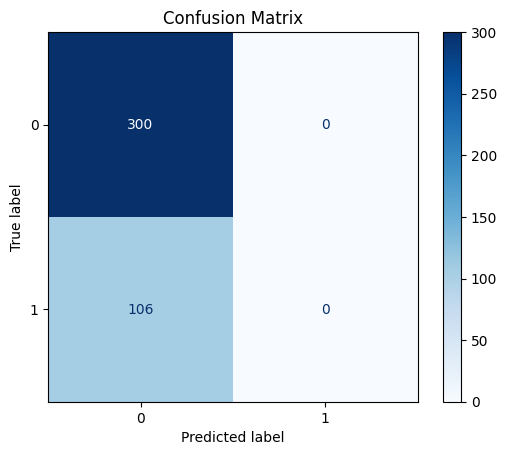

True Negatives (TN): 300
False Positives (FP): 0
False Negatives (FN): 106
True Positives (TP): 0


In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.show()

# Print confusion matrix values
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

The above plot is a confusion matrix to show us visual the number of True Positives (TP), True Negatives (NP), False Positives (FP), and False Negatives (NP). This is important because it helps us explain why 1, accuracy on it's own is a bad metric & 2, why the other metrics are so low.

Firstly accuracy is a bad metric, because as I stated in my previous entry y=0 being your model is not helpful in terms of trying to find out if the subject is doing a task based on brain signals, which is the main point of prediction in this case. 

---

Secondly lets now go over the calculation of Balanced Accuracy and F1 Score.

Balanced Accuracy = $\frac{1}{2}$ ($\frac{TP}{TP + FN}$ + $\frac{TN}{TN + FP}$) = $\frac{1}{2}$($\frac{0}{106}$ + $\frac{300}{300}$) = $\frac{1}{2}$ $\frac{300}{300}$ = $\frac{1}{2}$ = 0.5 = 50%

F1 Score = 2 * $\frac{\frac{TP}{TP + FP} * \frac{TP}{TP + FN}}{\frac{TP}{TP + FP} + \frac{TP}{TP + FN}}$ = 2 * $\frac{0 * \frac{0}{106}}{0 + \frac{0}{106}}$ = 0 = 0%

Because the distribution of picking both y=0 and y=1 is one sided towards 0 is what is weighing both of these metrics down.